This tutorial demonstrates polynomial fitting through linear regression. It consists of two sections:

- **Section I**: An implementation of polynomial regression to understand each part of the code.
- **Section II**: Experiments and modifications to explore the impact of different parameters on the results.

*What are you expected to do?*

In Section I, the whole code is already implemented. You are expected to read and understand what each part of the code does. Section II contains 3 questions: Questions 1 and 2 require you to change a few parameters in Section I and to observe and comment on the result. In Question 3 you have to modify a part of the code to add confidence interval boundaries on the plot, and then to comment on the result.

You are requested to write your responses to the three questions on paper and, if you want, draw a sketch of the graph that is obtained in Question 3. There is no need to reproduce or send your code: what matters is your interpretation of the experimental results.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import t

We aim to approximate a function $f$ over an interval $I = [-1,1]$ using a polynomial of degree $p$.

Given noisy observations $(x_i, y_i)$ where:
$$
y_i = f(x_i) + \epsilon_i,
$$
we solve the least squares problem:
$$
\min_{\beta \in \mathbb{R}^{p+1}} \sum_{i=1}^n |y_i - (\beta_0 + \beta_1 x_i + \cdots + \beta_p (x_i)^p)|^2,
$$
which is equivalent to performing linear regression with a design matrix:
$$
\mathbf{x}_n = \begin{pmatrix}
    1 & x_1  & \cdots & (x_1)^p\\
    \vdots & \vdots & & \vdots\\
    1 & x_n & \cdots & (x_n)^p
\end{pmatrix}.
$$

## Section I: Implementation of Polynomial Regression

### Step 1: Define the Polynomial Function $f(x)$
For this tutorial, we define the function $f(x) = 1 + 3x - 4.5x^3 + x^5 + x^8$, and we will visualize it.

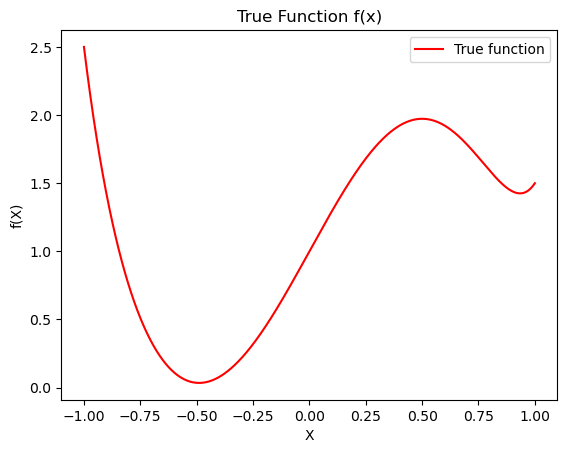

In [2]:
# Define the polynomial function
def f(x):
    return 1 + 3 * x - 4.5 * x**3 + x**5 + x**8

# Generate points to plot the true function
n_plot = 1000
VectOfX = np.linspace(-1, 1, n_plot)
VectOfY = f(VectOfX)

# Plot the true function
plt.plot(VectOfX, VectOfY, 'r-', label="True function")
plt.xlabel("X")
plt.ylabel("f(X)")
plt.title("True Function f(x)")
plt.legend()
plt.show()

### Step 2: Create the Design Matrix

The `create_matrix` function returns an $n \times (p+1)$ matrix where each row contains the powers of $x_i$ from $0$ up to $p$.


In [3]:
def create_matrix(X, p):
    n = len(X)
    Xn = np.zeros((n, p + 1))
    for i in range(n):
        for j in range(p + 1):
            Xn[i, j] = X[i] ** j
    return Xn

### Step 3: Construct Sample Data

To simulate the noisy observations, we randomly generate 25 sample points in $[-1, 1]$, calculate $y_i = f(x_i)$, and add Gaussian noise $\epsilon_i \sim \mathcal{N}(0, \sigma^2)$ with $\sigma = 0.1$.

In [4]:
np.random.seed(0)  # For reproducibility
n = 25  # number of points
SampleOfX = np.random.uniform(-1, 1, n)
sigma = 0  # standard deviation of the noise
Yn = f(SampleOfX) + sigma * np.random.normal(0, 1, n)

### Step 4: Perform Polynomial Regression

Using a polynomial of order $p = 10$, we build the design matrix and perform linear regression without an intercept.

In [5]:
p = 3  # Order of the polynomial
Xn = create_matrix(SampleOfX, p)  # Design matrix

# Perform linear regression without intercept
model = LinearRegression(fit_intercept=False)
model.fit(Xn, Yn)
EstimBeta = model.coef_  # Coefficients of the polynomial
EstimBeta

array([ 0.96037593,  2.48369168,  0.54603261, -3.03438128])

### Step 5: Plot the Estimated Function

To visualize the estimated function $\hat{f}(x) = \hat{\beta}_0 + \hat{\beta}_1 x + \cdots + \hat{\beta}_p x^p$, we evaluate it over the interval $I = [-1,1]$ and plot it along with the data points and the true function.


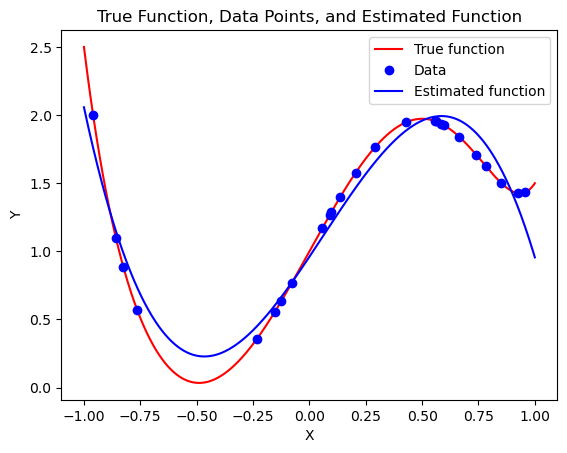

In [6]:
# Estimator of f(x) at all points of the grid VectOfX
EstimY = create_matrix(VectOfX, p) @ EstimBeta

# Plotting
plt.plot(VectOfX, VectOfY, 'r-', label="True function")  # True function in red
plt.plot(SampleOfX, Yn, 'bo', label="Data")  # Data points in blue
plt.plot(VectOfX, EstimY, 'b-', label="Estimated function")  # Estimated function in blue
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.title("True Function, Data Points, and Estimated Function")
plt.show()

## Section II: Experiments

### 1. Change in the Number of Parameters

**Question 1**: Run the code above with different values of $p$ (e.g., from 1 to 10) without modifying `SampleOfX` or `Yn`. Observe the resulting estimations of both $\beta$ and $f$.

Degrés faibles (p=1, 2) : le modèle ne prend pas en comptela non-linéarité de la fonction, ce qui conduit à un underfitting.
Degrés élevés (p>=8) : cette fois-ci overfitting.

Valeurs intermédiaires (p entre 3 et 5) : compromis permettant au modèle de mieux représenter la fonction réelle sans surréagir au bruit.

**Question 2**: Repeat the experiment with $\sigma = 0$. Observe the differences in the estimates of $f$ without noise.

En mettant sigma=0 (pas de bruit), le modèle produit une courbe plus régulière, particulièrement pour les valeurs de p élevées. Cela réduit l'effet de l'overfitting.

Valeurs des coefficients beta : Les coefficients sont plus stables et proches des valeurs réelles du polynôme.

Meilleur équilibre biais variance

### 2. Confidence Intervals

For a chosen $p$, add boundaries for the 95% confidence interval around the estimated function. We compute the estimator for $\sigma$ and the quantile for the 95% confidence level as follows:

In [14]:
EstimSigma = np.sqrt(np.sum((Yn - Xn @ EstimBeta) ** 2) / (n - p - 1)) # Estimator of sigma
Quantile = t.ppf(0.975, n - p - 1) # Quantile of Student distribution

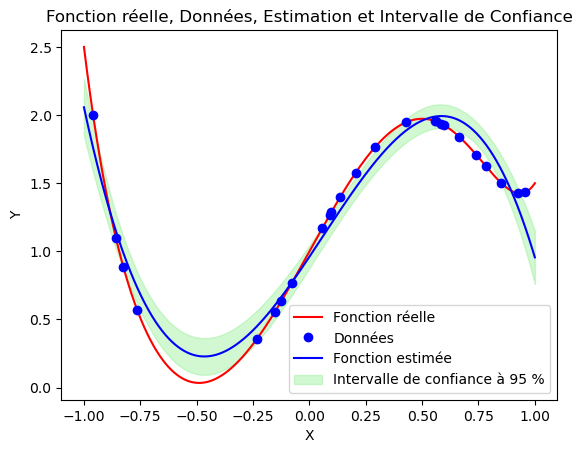

In [16]:
ConfidenceInterval = []
UpperBound = []
LowerBound = []

for x0 in VectOfX:
    x0_vector = create_matrix(np.array([x0]), p)  # Vecteur pour x0
    lambda_value = x0_vector @ np.linalg.inv(Xn.T @ Xn) @ x0_vector.T
    CI_value = Quantile * EstimSigma * np.sqrt(lambda_value)
    UpperBound.append(EstimY[np.where(VectOfX == x0)[0][0]] + CI_value)
    LowerBound.append(EstimY[np.where(VectOfX == x0)[0][0]] - CI_value)
    
UpperBound = np.array(UpperBound).flatten()
LowerBound = np.array(LowerBound).flatten()

# Tracé
plt.plot(VectOfX, VectOfY, 'r-', label="Fonction réelle")
plt.plot(SampleOfX, Yn, 'bo', label="Données")
plt.plot(VectOfX, EstimY, 'b-', label="Fonction estimée")
plt.fill_between(VectOfX, LowerBound, UpperBound, color='lightgreen', alpha=0.4, label="Intervalle de confiance à 95 %")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.title("Fonction réelle, Données, Estimation et Intervalle de Confiance")
plt.show()

**Question 3**: Comment on the behavior of the confidence interval boundaries in relation to the estimated function.

L'intervalle de confiance est bien sûr centré sur la fonction prédite (par construction). Là où il y a moins de données, l'intervalle s'élargit (c'est normal).